In [1]:
#for loading data
import pandas as pd
import json

#for llm
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

#similarity
import regex as re
from sentence_transformers import SentenceTransformer
from scipy.optimize import linear_sum_assignment

#visualization
#plot matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Preprocess data and sampling

In [3]:
job_statements = pd.read_excel("datasets/task_statements.xlsx")
job_statements.columns = job_statements.columns.str.lower()
job_statements = job_statements.drop(labels=["incumbents responding","date","domain source"], axis=1).rename(columns={"o*net-soc code":"code", "task type":"type", "task id": "id", "task":"ref_task"})
job_statements = job_statements[~job_statements["type"].str.contains("Supplemental", case=False, na=True)]
job_statements["ind"] = job_statements["code"].str[:2]
job_statements = job_statements.groupby("title").agg({"ref_task":list, "ind": "first"}).reset_index().sort_values("ind")
sampled_occupation = job_statements.groupby('ind', group_keys=False).sample(frac=0.05, random_state=1) #43 samples
sampled_occupation

,title,ref_task,ind
478,Lodging Managers,[Answer inquiries pertaining to hotel policies...,11
777,Spa Managers,"[Respond to customer inquiries or complaints.,...",11
833,Training and Development Managers,[Analyze training needs to develop new trainin...,11
203,Customs Brokers,[Prepare and process import and export documen...,13
386,Government Property Inspectors and Investigators,"[Prepare correspondence, reports of inspection...",13
856,Video Game Designers,[Balance and adjust gameplay experiences to en...,15
559,Nanosystems Engineers,[Provide scientific or technical guidance or e...,17
430,Industrial Engineers,"[Estimate production costs, cost saving method...",17
799,Surveying and Mapping Technicians,"[Position and hold the vertical rods, or targe...",17
170,Conservation Scientists,[Apply principles of specialized fields of sci...,19


In [4]:
#for trial
trial_df = sampled_occupation.sample(5, random_state= 1)
test_sample_list =[trial_df.iloc[x]["title"] for x in range(5)]

### Set up functions

In [ ]:
#get reference description
def get_des (title):
    task_list = sampled_occupation.query("title == @title")["ref_task"].iloc[0]
    return task_list

In [6]:
def task_gen(title,model,system = False):
    class occupation(BaseModel):
        occupation: str
        tasks: list[str]

    #initialize model
    model= model

    query = "Generate "+str(len(get_des(title)))+" task statements that "+ title +" would perform at work."

    if system == False:
        prompt_template = ChatPromptTemplate([
            ("human","{input}")
            ]
        )
    else:
        prompt_template = ChatPromptTemplate([
            ("system", system),
            ("human","{input}")
            ]
        )

    structured_llm = model.with_structured_output(schema=occupation.model_json_schema())

    prompt = prompt_template.invoke({"input": query})
    response = structured_llm.invoke(prompt)

    return response
    

In [34]:
# parse response
def parse_response(response):
    try:
        parsed = json.loads(response["tasks"])
        return parsed
    except:
        try:
            parsed = response["tasks"]
            return parsed
        except:
            return np.nan

In [8]:
#pre process text
def preProcessText(text=list):
	processed = []
	for doc in text:
		doc = re.sub(r"\\n", "", doc)
		doc = re.sub(r"\W", " ", doc) #remove non words char
		doc = re.sub(r"\d"," ", doc) #remove digits char
		doc = re.sub(r'\s+[a-z]\s+', " ", doc) # remove a single char
		doc = re.sub(r'^[a-z]\s+', "", doc) #remove a single character at the start of a document
		doc = re.sub(r'\s+', " ", doc)  #replace an extra space with a single space
		doc = re.sub(r'^\s', "", doc) # remove space at the start of a doc
		doc = re.sub(r'\s$', "", doc) # remove space at the end of a document
		processed.append(doc.lower())
	return processed

In [61]:
#get similarity score
def sbert(ref, gen):
    sim_model = SentenceTransformer("all-mpnet-base-v2", similarity_fn_name="cosine")

    # Compute embeddings for both lists
    embeddings_ref = sim_model.encode(ref)
    embeddings_gen = sim_model.encode(gen)


    # Compute cosine similarities
    similarities = sim_model.similarity(embeddings_ref, embeddings_gen).numpy()
    return similarities

In [10]:
#plot graph
def plot(similarities):
    x_label = [x+1 for x in range(len(similarities))]
    y_label = [chr(num + 96) for num in x_label]
    plt.figure(figsize=(12, 12))
    sns.heatmap(similarities, annot=True, fmt=".3f", cmap="crest", xticklabels=x_label, yticklabels=y_label)
    plt.title("Sentence Cosine Similarity for "+ test_occ)
    plt.xlabel("O*NET Data")
    plt.ylabel("Generated Sentence")
    plt.savefig("results/"+test_occ+".png")
    plt.show()
    return plt

In [11]:
def match(ref, gen):
    try:
        ref_clean = preProcessText(ref)
        gen_clean = preProcessText(gen)
        matrix = sbert(ref_clean, gen_clean)
        row_ind, col_ind = linear_sum_assignment(1 - matrix)  # Minimize cost (1 - similarity)
        assigned_similarities = matrix[row_ind, col_ind]
        return np.mean(assigned_similarities), matrix, row_ind.tolist(), col_ind.tolist()
    except:
        return np.nan

### packaging things for repeated excution

In [12]:
model = ChatOllama(model="llama3.2", temperature=0.8, seed= 1)

In [ ]:
for title in test_sample_list:
    generated_statements = task_gen(title, model)
    trial_df.loc[trial_df["title"] == title, "gen_task"] = [generated_statements]

trial_df

,title,ref_task,ind,gen_task
203,Customs Brokers,[Prepare and process import and export documen...,13,"{'occupation': 'Customs Broker', 'tasks': '[""C..."
833,Training and Development Managers,[Analyze training needs to develop new trainin...,11,{'occupation': 'Training and Development Manag...
178,"Cooks, Institution and Cafeteria",[Monitor and record food temperatures to ensur...,35,"{'occupation': 'Cook', 'tasks': '[""Prepare ing..."
607,"Painting, Coating, and Decorating Workers","[Apply coatings, such as paint, ink, or lacque...",51,"{'occupation': 'Painting', 'tasks': '[""Apply p..."
388,Graphic Designers,[Key information into computer equipment to cr...,27,"{'occupation': 'Graphic Designer', 'tasks': '[..."


In [38]:
result_df = trial_df.reset_index(drop=True)
result_df["parsed_response"] = result_df["gen_task"].apply(parse_response)
result_df = result_df.dropna()
result_df

,title,ref_task,ind,gen_task,parsed_response
0,Customs Brokers,[Prepare and process import and export documen...,13,"{'occupation': 'Customs Broker', 'tasks': '[""C...","[Clearing shipments from import customs, Inspe..."
1,Training and Development Managers,[Analyze training needs to develop new trainin...,11,{'occupation': 'Training and Development Manag...,"[Develop training programs for employees, Cond..."
2,"Cooks, Institution and Cafeteria",[Monitor and record food temperatures to ensur...,35,"{'occupation': 'Cook', 'tasks': '[""Prepare ing...","[Prepare ingredients, Cook meals, Clean kitchen]"
3,"Painting, Coating, and Decorating Workers","[Apply coatings, such as paint, ink, or lacque...",51,"{'occupation': 'Painting', 'tasks': '[""Apply p...","[Apply paint to walls, Mix paint colors, Clean..."
4,Graphic Designers,[Key information into computer equipment to cr...,27,"{'occupation': 'Graphic Designer', 'tasks': '[...",[Create visual elements for print and digital ...


In [39]:
result_df[["score", "matrix", "ref_order", "gen_order"]] = result_df.apply(lambda row: match(row["ref_task"], row["parsed_response"]), axis=1).apply(pd.Series)
result_df

,title,ref_task,ind,gen_task,parsed_response,score,matrix,ref_order,gen_order
0,Customs Brokers,[Prepare and process import and export documen...,13,"{'occupation': 'Customs Broker', 'tasks': '[""C...","[Clearing shipments from import customs, Inspe...",0.534684,"[[0.5681414, 0.4988519, 0.46135658, 0.48796222...","[0, 1, 2, 3, 4, 6, 8, 9, 11, 12, 13, 14, 15, 1...","[16, 0, 6, 1, 2, 17, 9, 3, 10, 7, 15, 11, 8, 1..."
1,Training and Development Managers,[Analyze training needs to develop new trainin...,11,{'occupation': 'Training and Development Manag...,"[Develop training programs for employees, Cond...",0.600575,"[[0.7108624, 0.4304707, 0.3950833, 0.6425809, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[9, 8, 7, 10, 2, 4, 3, 6, 1, 5, 0]"
2,"Cooks, Institution and Cafeteria",[Monitor and record food temperatures to ensur...,35,"{'occupation': 'Cook', 'tasks': '[""Prepare ing...","[Prepare ingredients, Cook meals, Clean kitchen]",0.548620,"[[0.32628417, 0.39149806, 0.23261246], [0.4852...","[1, 3, 5]","[1, 0, 2]"
3,"Painting, Coating, and Decorating Workers","[Apply coatings, such as paint, ink, or lacque...",51,"{'occupation': 'Painting', 'tasks': '[""Apply p...","[Apply paint to walls, Mix paint colors, Clean...",0.376314,"[[0.44194707, 0.39662975, 0.29959273], [0.0731...","[0, 1, 2]","[0, 1, 2]"
4,Graphic Designers,[Key information into computer equipment to cr...,27,"{'occupation': 'Graphic Designer', 'tasks': '[...",[Create visual elements for print and digital ...,0.520146,"[[0.45792484, 0.3233065, 0.3520056, 0.41437715...","[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[9, 6, 2, 1, 14, 7, 3, 4, 0, 12, 11, 13, 8, 5,..."


In [47]:
with open('result.json', 'w') as f:
    f.write(result_df.to_json(index=True))

In [51]:
analysis = result_df.describe().T
analysis["max_title"] = result_df.loc[result_df["score"].idxmax(), "title"]
analysis["min_title"] = result_df.loc[result_df["score"].idxmin(), "title"]
analysis

,count,mean,std,min,25%,50%,75%,max,max_title,min_title
score,5.0,0.516068,0.083808,0.376314,0.520146,0.534684,0.54862,0.600575,Training and Development Managers,"Painting, Coating, and Decorating Workers"


In [60]:
a1 = get_des('Cooks, Institution and Cafeteria')

a2 = ["Track and document food temperatures to maintain food safety standards.",
"Prepare meals following menus, dietary restrictions, and portion requirements.",
"Organize, rotate, and store food supplies properly.",
"Clean and sanitize pots, pans, dishes, utensils, and other kitchen tools.",
"Distribute and serve food to residents, staff, or customers.",
"Sanitize and inspect kitchen equipment, appliances, and workspaces to ensure proper functionality and cleanliness.",
"Prepare, cut, and cook meat, fish, and poultry.",
"Supervise one or more team members assisting with meal preparation and service.",
"Provide training to newly hired employees.",
"Conduct inventory checks on supplies and equipment.",
"Request food supplies, kitchen tools, and appliances based on anticipated demand.",
"Bake bread, rolls, and other pastry items."]

match(a1, a2)

(0.8695483,
 array([[0.91959333, 0.38639933, 0.36918652, 0.37106827, 0.36156347,
         0.45859307, 0.33582896, 0.387756  , 0.10696179, 0.32504886,
         0.3727135 , 0.19051045],
        [0.44487843, 0.8109475 , 0.40500402, 0.28890347, 0.5141749 ,
         0.28925714, 0.45229128, 0.50869125, 0.16260329, 0.22941788,
         0.47167322, 0.3289715 ],
        [0.3904283 , 0.3956255 , 0.93873703, 0.23654772, 0.4293189 ,
         0.2846582 , 0.23798028, 0.28370863, 0.04282889, 0.35772654,
         0.43743157, 0.3074156 ],
        [0.40784484, 0.2725699 , 0.28262013, 0.84922636, 0.32216293,
         0.7022685 , 0.40189874, 0.33122903, 0.12871693, 0.31220925,
         0.34267765, 0.27225077],
        [0.35821456, 0.5575633 , 0.4788184 , 0.29819807, 0.85784435,
         0.3861975 , 0.3143078 , 0.6509289 , 0.3363136 , 0.29144415,
         0.49826476, 0.26497495],
        [0.37340003, 0.22604293, 0.32161415, 0.70381093, 0.4113821 ,
         0.8819101 , 0.32013607, 0.45672604, 0.23141259, 0.

In [64]:
b1 = get_des('Cooks, Institution and Cafeteria')
b2 = [
    "Monitor and log food temperatures to uphold food safety.",
    "Prepare food items according to menus, dietary restrictions, or portion requirements.",
    "Store and rotate food supplies appropriately.",
    "Wash and sanitize pots, pans, dishes, utensils, and other kitchenware.",
    "Portion and serve meals to facility residents, staff, or guests.",
    "Clean and inspect kitchen equipment, appliances, and work areas for sanitation and functionality.",
    "Cut, clean, and cook meat, fish, or poultry.",
    "Oversee the tasks of workers assisting with meal preparation and service.",
    "Train newly hired staff members.",
    "Take stock of supplies and kitchen equipment.",
    "Request food supplies, kitchen tools, and appliances based on projected needs.",
    "Bake bread, rolls, and various pastries."
]

res = match(b1, b2)
res[1]

array([[0.9679525 , 0.46598345, 0.43312305, 0.39651355, 0.33183837,
        0.46486127, 0.33006895, 0.407718  , 0.04882509, 0.37399268,
        0.34875074, 0.17588666],
       [0.41536388, 0.8589548 , 0.5064154 , 0.32629824, 0.65188813,
        0.32000533, 0.39103547, 0.5254257 , 0.09923236, 0.3667662 ,
        0.45777577, 0.34824556],
       [0.386711  , 0.45344332, 0.9207758 , 0.2372357 , 0.37555593,
        0.3007185 , 0.2440466 , 0.30735043, 0.05473725, 0.53666395,
        0.4179599 , 0.28461057],
       [0.38523427, 0.356907  , 0.29331887, 0.89042354, 0.25771245,
        0.6920255 , 0.46003574, 0.3966532 , 0.10749042, 0.55100787,
        0.3567536 , 0.25561002],
       [0.34758443, 0.6118545 , 0.5422811 , 0.30932975, 0.8908942 ,
        0.43538457, 0.2741167 , 0.6963302 , 0.31221375, 0.46489197,
        0.4820693 , 0.26764208],
       [0.3741892 , 0.29559815, 0.30482122, 0.67177045, 0.3433261 ,
        0.9127015 , 0.35933506, 0.5560119 , 0.22344613, 0.6193286 ,
        0.43658733,

NameError: name 'test_occ' is not defined

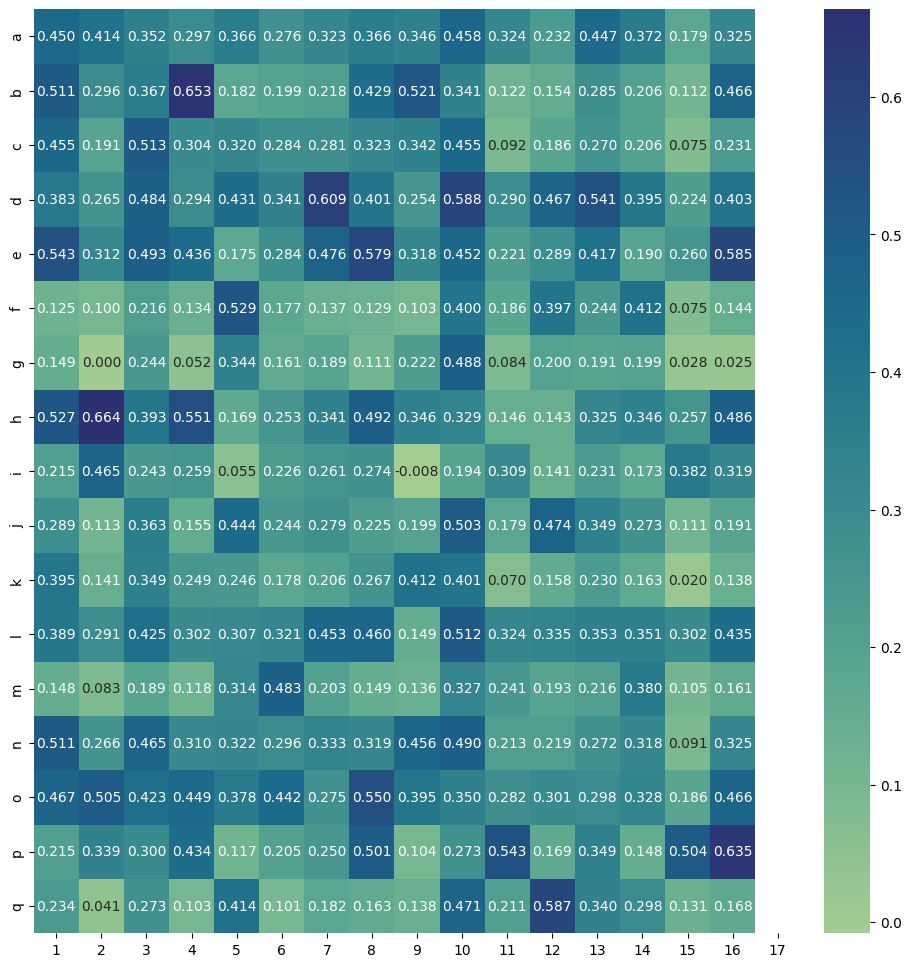

In [89]:
tasks = result_df.iloc[4]["parsed_response"]
order = result_df.iloc[4]["gen_order"]
rearranged_sentences = [s for _,s in sorted(zip(order, tasks))]

res2 = match(get_des("Graphic Designers"), rearranged_sentences)
plot(res2[1])
